In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit


In [347]:
def fill(start_date, end_date, previous_df, df):

    # Prepare data for training the model
    X_train = previous_df['pv_measurement'].values.reshape(-1, 1)
    y_train = previous_df['pv_measurement'].values

    # Initialize and train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)


    # Find the corresponding time range in the previous dataset
    previous_missing_data_df = previous_df[(previous_df['time'] >= start_date) & (previous_df['time'] <= end_date)]

    # Prepare the data that we have for prediction
    X_missing = previous_missing_data_df['pv_measurement'].values.reshape(-1, 1)

    # Impute the missing data using the trained model
    y_missing_imputed = model.predict(X_missing)

    # Prepare the new time range to fill in the current dataset
    missing_time_range = pd.date_range(start=start_date, end=end_date, freq='H')[:-1]  # Exclude the last point to match the number of hours
    len_y_missing_imputed = len(y_missing_imputed)
    len_missing_time_range = len(missing_time_range)

    len_y_missing_imputed, len_missing_time_range
    # Create a DataFrame for the imputed data
    adjusted_missing_time_range = missing_time_range[:len_y_missing_imputed]

    y_missing_imputed = y_missing_imputed[:len(missing_time_range)]


    # Create a DataFrame for the imputed data
    imputed_df = pd.DataFrame({
        'time': adjusted_missing_time_range,
        'pv_measurement': y_missing_imputed
    })

    # Append the imputed data to the current dataset and sort by time
    df = pd.concat([df, imputed_df], ignore_index=True).sort_values(by='time').reset_index(drop=True)

    # Find the peak value in the previous dataset
    peak_previous = previous_df['pv_measurement'].max()

    # Find the peak value in the current dataset (excluding the imputed range)
    peak_current = df[df['time'] < start_date]['pv_measurement'].max()

    # Calculate the scaling factor
    scaling_factor = peak_current / (peak_previous)

    # Scale down the imputed values using the scaling factor
    df.loc[(df['time'] >= start_date) & (df['time'] <= end_date), 'pv_measurement'] *= scaling_factor

    # plt.figure(figsize=(18, 6))
    # plt.plot(df['time'], df['pv_measurement'], marker='o', markersize=2, linestyle='-')
    # plt.title('PV Measurement with Scaled Imputed Values')
    # plt.xlabel('Time')
    # plt.ylabel('PV Measurement')
    # plt.show()

    return df

In [348]:
x_target_A = pd.read_parquet('/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/A/train_targets.parquet')
x_train_obs_A = pd.read_csv('../Mathias/pipeline/data/obs_A.csv')
x_train_est_A = pd.read_csv('../Mathias/pipeline/data/est_A.csv')

x_target_B = pd.read_parquet('/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/B/train_targets.parquet')
x_train_obs_B = pd.read_csv('../Mathias/pipeline/data/obs_B.csv')
x_train_est_B = pd.read_csv('../Mathias/pipeline/data/est_B.csv')


x_target_C = pd.read_parquet('/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/C/train_targets.parquet')
x_train_obs_C = pd.read_csv('../Mathias/pipeline/data/obs_C.csv')
x_train_est_C = pd.read_csv('../Mathias/pipeline/data/est_C.csv')

In [349]:
def evaluate_model_performance(y_true, y_pred, model_name, location):
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Print metrics
    print(f"Performance for {model_name} at {location}:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared: {r2:.2f}")
    print("-" * 50)


# # Splitting data into features and target for Location B
# X_train_B = x_train_obs_B.drop(columns=['time', 'pv_measurement'])
# y_train_B = x_train_obs_B['pv_measurement']

# X_test_B = x_train_est_B.drop(columns=['time', 'pv_measurement'])
# y_test_B = x_train_est_B['pv_measurement']

# # Linear Regression for Location B
# lr_B = LinearRegression()
# lr_B.fit(X_train_B, y_train_B)
# lr_pred_B = lr_B.predict(X_test_B)
# evaluate_model_performance(y_test_B, lr_pred_B, "Linear Regression", "Location B")

# # Random Forest for Location B
# rf_B = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=0)
# rf_B.fit(X_train_B, y_train_B)
# rf_pred_B = rf_B.predict(X_test_B)
# evaluate_model_performance(y_test_B, rf_pred_B, "Random Forest", "Location B")

# # XGBoost for Location B
# xg_reg_B = xgb.XGBRegressor(objective ='reg:absoluteerror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 100)
# xg_reg_B.fit(X_train_B, y_train_B)
# xg_pred_B = xg_reg_B.predict(X_test_B)
# evaluate_model_performance(y_test_B, xg_pred_B, "XGBoost", "Location B")


In [350]:
# start_dates_B = ['2022-05-01', '2020-07-15', '2020-04-01', '2021-01-30']
# end_dates_B = ['2022-11-01', '2020-08-26', '2020-04-17', '2021-05-01']


# for i in range(len(start_dates_B)):
#     x_target_B = fill(start_dates_B[i], end_dates_B[i], x_target_A, x_target_B)



In [351]:
# start_dates_C = ['2022-04-25', '2022-04-25']
# end_dates_C = ['2022-11-01', '2023-07-01']

# for i in range(len(start_dates_C)):
#     x_target_C = fill(start_dates_C[i], end_dates_C[i], x_target_A, x_target_C)

In [352]:
def evaluate_models(X_train, y_train, X_test, y_test, location):
    models = {}  # Initialize the dictionary here

    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)
    evaluate_model_performance(y_test, lr_pred, "Linear Regression", location)

    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=0)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    evaluate_model_performance(y_test, rf_pred, "Random Forest", location)

    # XGBoost
    xg_reg = xgb.XGBRegressor(objective ='reg:absoluteerror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 100)
    xg_reg.fit(X_train, y_train)
    xg_pred = xg_reg.predict(X_test)
    evaluate_model_performance(y_test, xg_pred, "XGBoost", location)

    models['lr'] = lr
    models['rf'] = rf
    models['xg_reg'] = xg_reg
    return models

# Evaluate the models for each location
models_A = evaluate_models(X_train_A, y_train_A, X_test_A, y_test_A, "Location A")
models_B = evaluate_models(X_train_B, y_train_B, X_test_B, y_test_B, "Location B")
models_C = evaluate_models(X_train_C, y_train_C, X_test_C, y_test_C, "Location C")

# Make future predictions

# Make future predictions for Location A
y_future_pred_A_lr = models_A['lr'].predict(x_future_A)
y_future_pred_A_rf = models_A['rf'].predict(x_future_A)
y_future_pred_A_xg = models_A['xg_reg'].predict(x_future_A)

# Make future predictions for Location B
y_future_pred_B_lr = models_B['lr'].predict(x_future_B)
y_future_pred_B_rf = models_B['rf'].predict(x_future_B)
y_future_pred_B_xg = models_B['xg_reg'].predict(x_future_B)

# Make future predictions for Location C
y_future_pred_C_lr = models_C['lr'].predict(x_future_C)
y_future_pred_C_rf = models_C['rf'].predict(x_future_C)
y_future_pred_C_xg = models_C['xg_reg'].predict(x_future_C)



Performance for Linear Regression at Location A:
Mean Absolute Error (MAE): 0.03
R-squared: 0.58
--------------------------------------------------
Performance for Random Forest at Location A:
Mean Absolute Error (MAE): 0.03
R-squared: 0.61
--------------------------------------------------
Performance for XGBoost at Location A:
Mean Absolute Error (MAE): 0.10
R-squared: -0.29
--------------------------------------------------
Performance for Linear Regression at Location B:
Mean Absolute Error (MAE): 0.07
R-squared: 0.36
--------------------------------------------------
Performance for Random Forest at Location B:
Mean Absolute Error (MAE): 0.16
R-squared: -1.86
--------------------------------------------------
Performance for XGBoost at Location B:
Mean Absolute Error (MAE): 0.11
R-squared: -0.23
--------------------------------------------------
Performance for Linear Regression at Location C:
Mean Absolute Error (MAE): 0.06
R-squared: 0.07
----------------------------------------

NameError: name 'x_future_A' is not defined

In [ ]:
def save_predictions(y_preds, location):
    pred_series_lr = pd.Series(y_preds['lr'], name=f"prediction_{location}_lr")
    pred_series_rf = pd.Series(y_preds['rf'], name=f"prediction_{location}_rf")
    pred_series_xg = pd.Series(y_preds['xg'], name=f"prediction_{location}_xg")

    all_predictions = pd.concat([pred_series_lr, pred_series_rf, pred_series_xg], axis=1)
    all_predictions = all_predictions.reset_index()
    all_predictions.rename(columns={'index': 'id'}, inplace=True)
    all_predictions.to_csv(f'predictions_future_{location}.csv', index=False)

# Save predictions for each location
save_predictions({'lr': y_future_pred_A_lr, 'rf': y_future_pred_A_rf, 'xg': y_future_pred_A_xg}, 'A')
save_predictions({'lr': y_future_pred_B_lr, 'rf': y_future_pred_B_rf, 'xg': y_future_pred_B_xg}, 'B')
save_predictions({'lr': y_future_pred_C_lr, 'rf': y_future_pred_C_rf, 'xg': y_future_pred_C_xg}, 'C')

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

def add_lags(df):
    target_map = df['pv_measurement'].to_dict()
    df['lag 1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag 2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag 3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df


In [ ]:
def time_series_prediction_and_scaling(x_target, location_name):
    x_target.set_index('time', inplace=True)
    x_target.index = pd.to_datetime(x_target.index)
    x_target.sort_index(inplace=True)
    x_target.dropna(inplace=True)

    tss = TimeSeriesSplit(n_splits=5, test_size=24*30)
    preds = []
    scores = []

    for train_idx, val_idx in tss.split(x_target):
        train = x_target.iloc[train_idx]
        test = x_target.iloc[val_idx]
        train = create_features(train)
        test = create_features(test)
        train = add_lags(train)
        test = add_lags(test)

        FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag 1', 'lag 2', 'lag 3']
        TARGET = 'pv_measurement'

        X_train = train[FEATURES].fillna(0)
        y_train = train[TARGET]
        X_test = test[FEATURES].fillna(0)
        y_test = test[TARGET]

        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000, early_stopping_rounds=50, objective='reg:linear', max_depth=3, learning_rate=0.01)
        reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)

    print(f'{location_name} - score across folds: {np.mean(scores):0.4f};')
    print(f'{location_name} - fold scores are: {scores}')

    scaling_factor = np.mean(y_train) / np.mean(y_pred)
    corrected_y_pred = y_pred * scaling_factor

    plt.figure(figsize=(14, 7))
    plt.plot(test.index, y_test, label='Actual')
    plt.plot(test.index, corrected_y_pred, label='Scaled Predicted')
    plt.title(f'Time Series Prediction for {location_name}')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.legend()
    plt.show()

    return reg



[11:57:14] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1348.50512	validation_1-rmse:128.59327
[55]	validation_0-rmse:1057.54891	validation_1-rmse:190.33657
[11:57:14] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1333.05456	validation_1-rmse:180.61053
[62]	validation_0-rmse:1025.21201	validation_1-rmse:189.31996
[11:57:15] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1318.26177	validation_1-rmse:339.41247
[100]	validation_0-rmse:924.39392	va

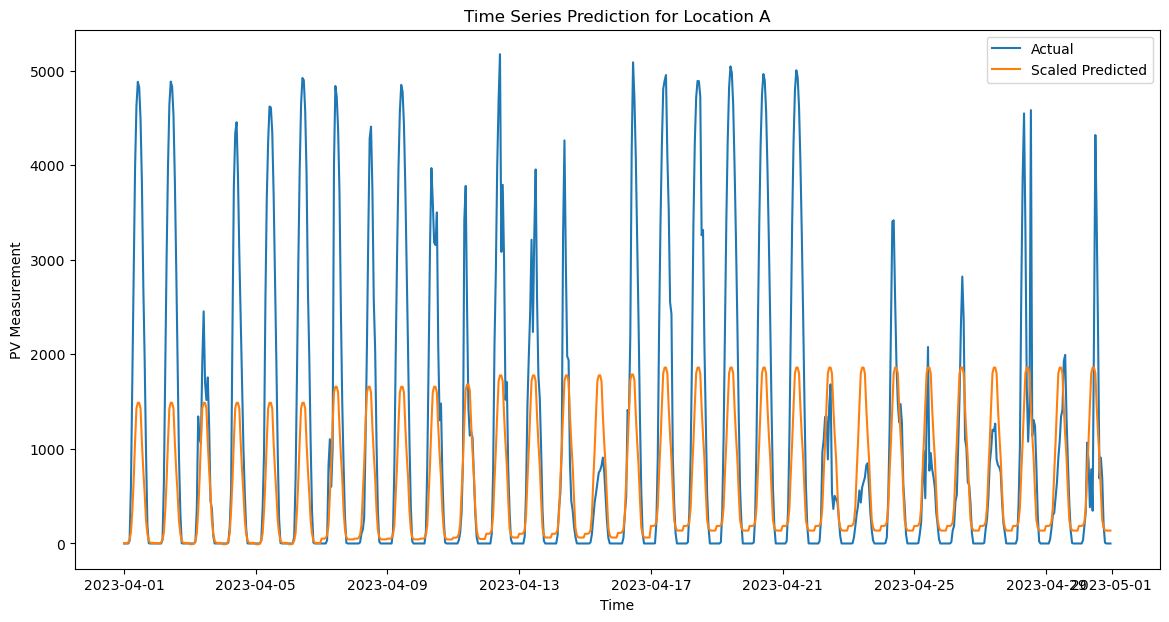

[11:57:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:222.51462	validation_1-rmse:25.05842
[100]	validation_0-rmse:162.85068	validation_1-rmse:21.14504
[178]	validation_0-rmse:143.22525	validation_1-rmse:22.45466
[11:57:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:219.83773	validation_1-rmse:9.78316
[58]	validation_0-rmse:177.76429	validation_1-rmse:11.85068
[11:57:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:217.24878	validation_1

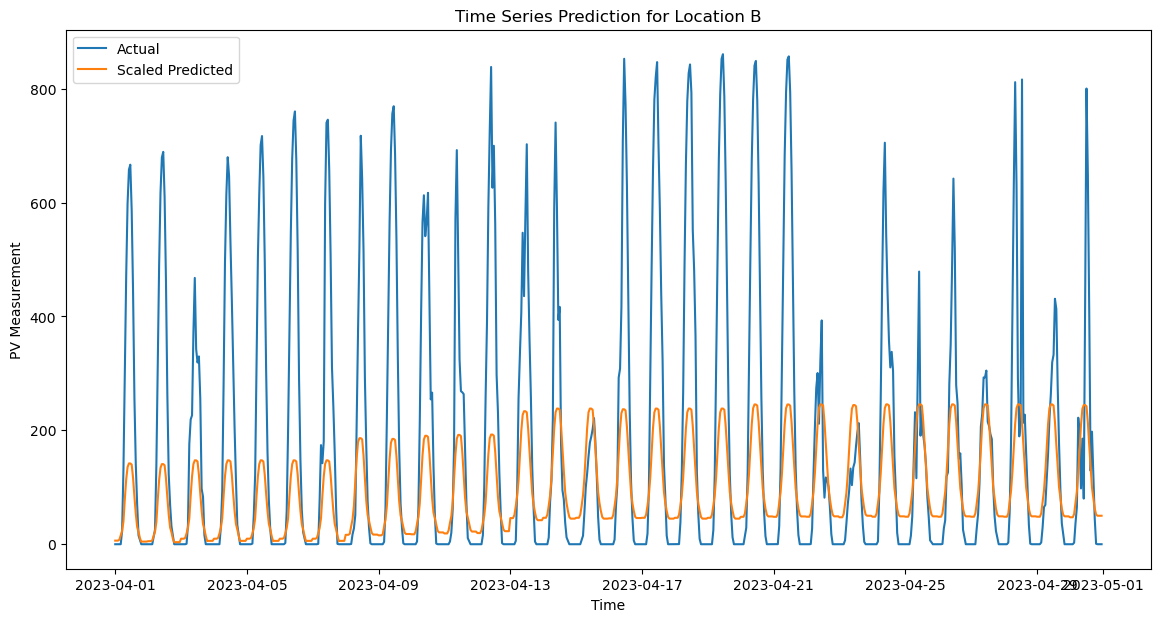

[11:57:45] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:187.44753	validation_1-rmse:224.32385
[100]	validation_0-rmse:138.31569	validation_1-rmse:193.87238
[200]	validation_0-rmse:116.80792	validation_1-rmse:167.37634
[300]	validation_0-rmse:105.11914	validation_1-rmse:152.78508
[400]	validation_0-rmse:98.94426	validation_1-rmse:147.95996
[500]	validation_0-rmse:95.13738	validation_1-rmse:143.37993
[600]	validation_0-rmse:92.38619	validation_1-rmse:139.95667
[700]	validation_0-rmse:90.12845	validation_1-rmse:137.29265
[800]	validation_0-rmse:88.39436	validation_1-rmse:135.51897
[900]	validation_0-rmse:86.82579	validation_1-rmse:133.99425
[999]	validation_0-rmse:85.51647	validation_1-rmse:132.67913
[11:57:50] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675

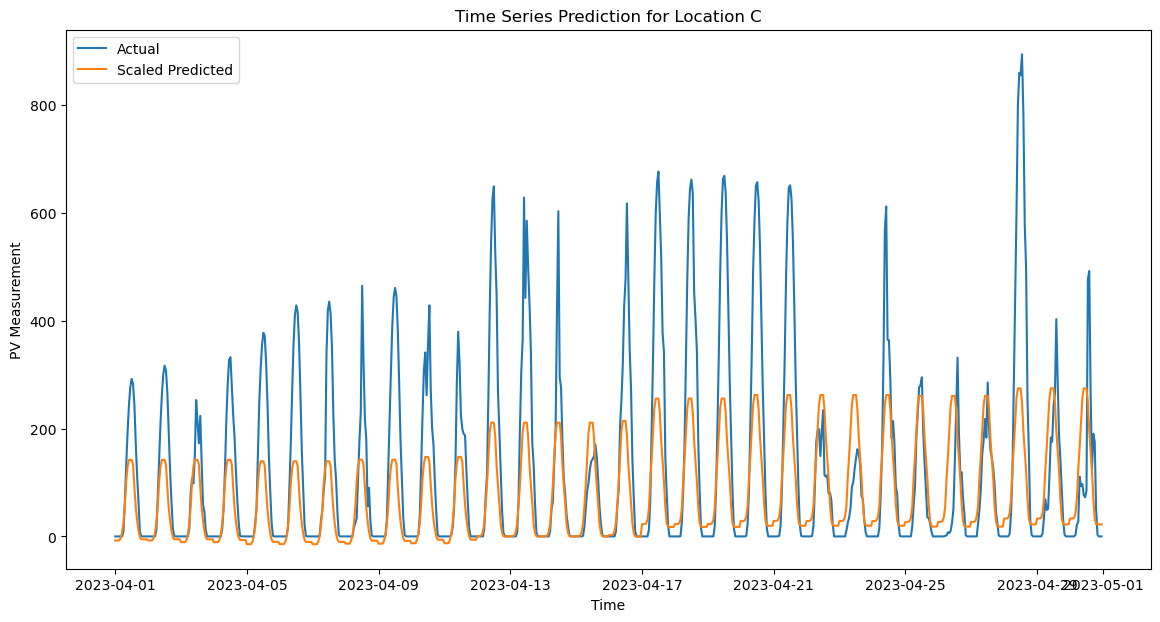

In [ ]:
trained_model_A = time_series_prediction_and_scaling(x_target_A, "Location A")
trained_model_B = time_series_prediction_and_scaling(x_target_B, "Location B")
trained_model_C = time_series_prediction_and_scaling(x_target_C, "Location C")


In [ ]:

# Create synthetic test data for future dates
future_dates = pd.date_range(start='2023-10-03', end='2023-11-02', freq='H')  # Adjust these dates
x_test_synthetic_A = pd.DataFrame({'time': future_dates})
x_test_synthetic_B = pd.DataFrame({'time': future_dates})
x_test_synthetic_C = pd.DataFrame({'time': future_dates})



y_pred_A = trained_model_A.predict(x_test_synthetic_A)  # Replace 'trained_model_A' with your actual model
y_pred_B = trained_model_B.predict(x_test_synthetic_B)
y_pred_C = trained_model_C.predict(x_test_synthetic_C)

In [ ]:
y_pred_A = trained_model_A.predict(x_test_synthetic_A[FEATURES].fillna(0))  # Replace FEATURES with your actual features
y_pred_B = trained_model_B.predict(x_test_synthetic_B[FEATURES].fillna(0))
y_pred_C = trained_model_C.predict(x_test_synthetic_C[FEATURES].fillna(0))


KeyError: "None of [Index(['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag 1',\n       'lag 2', 'lag 3'],\n      dtype='object')] are in the [columns]"

In [ ]:
# Convert predictions to Pandas Series
pred_series_A = pd.Series(y_pred_A, name="prediction_A")
pred_series_B = pd.Series(y_pred_B, name="prediction_B")
pred_series_C = pd.Series(y_pred_C, name="prediction_C")

# Concatenate the series
all_predictions = pd.concat([pred_series_A, pred_series_B, corrected_pred_series_C], axis=1)

# Create an 'id' column
all_predictions = all_predictions.reset_index()
all_predictions.rename(columns={'index': 'id'}, inplace=True)

# Save to CSV
all_predictions.to_csv('predictions.csv', index=False)

NameError: name 'y_pred_A' is not defined